In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchmetrics.classification import Accuracy, Dice
import matplotlib.pyplot as plt
import numpy as np

if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("GPU is available")
else:
    device = torch.device("cpu")   # Use the CPU
    print("GPU is not available")


GPU is available


In [2]:

# 1. Load Dataset with a Data Augmentation pipeline
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Using CIFAR-10 as an example
dataset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True, transform=transform)
num_classes = len(dataset.classes) # CIFAR-10 has 10 classes

# Split into Train/Test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [3]:
# 2. Load Pre-trained Model and Fine-Tune
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes) 
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
accuracy = Accuracy(task="multiclass", num_classes=num_classes)
mDice = Dice(average='macro', num_classes=num_classes)

In [4]:
# 3. Training and Evaluation

# Train and test functions
def train(model, loader):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    all_preds, all_labels = [], []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Store predictions and labels as tensors
        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())
    
    # Concatenate all batches into single tensors
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    # Calculate metrics
    train_accuracy = accuracy(all_preds, all_labels)
    train_mDice = mDice(all_preds, all_labels)
    
    return running_loss / len(loader), train_accuracy, train_mDice

def test(model, loader):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels as tensors
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate all batches into single tensors
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    # Calculate metrics
    test_accuracy = accuracy(all_preds, all_labels)
    test_mDice = mDice(all_preds, all_labels)
    
    return running_loss / len(loader), test_accuracy, test_mDice

In [5]:
# Tracking metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_mdice, test_mdice = [], []

# Main training Loop
for epoch in range(2):
    train_loss, train_accuracy, train_mDice = train(model, train_loader)
    test_loss, test_accuracy, test_mDice = test(model, test_loader)

    # Store metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    train_mdice.append(train_mDice)
    test_mdice.append(test_mDice)

    print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train mDice: {train_mDice:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}, Test mDice: {test_mDice:.4f}")

Epoch 1: Train Loss: 1.2332, Train Acc: 0.5723, Train mDice: 0.5710 | Test Loss: 1.0171, Test Acc: 0.6490, Test mDice: 0.6465
Epoch 2: Train Loss: 0.9251, Train Acc: 0.6864, Train mDice: 0.6853 | Test Loss: 0.8888, Test Acc: 0.6942, Test mDice: 0.6963


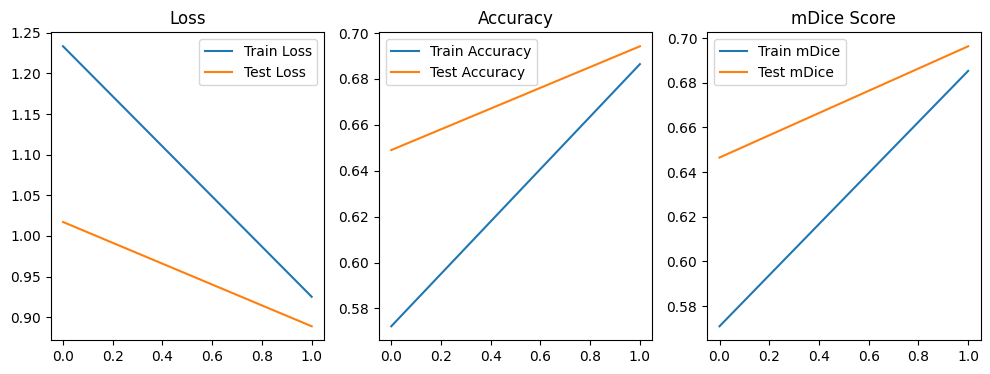

In [6]:
# 4. Plot Results
plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

# mDice Plot
plt.subplot(1, 3, 3)
plt.plot(train_mdice, label='Train mDice')
plt.plot(test_mdice, label='Test mDice')
plt.title('mDice Score')
plt.legend()

plt.show()